In [ ]:
#default_exp fast.core

In [ ]:
#export
import albumentations as A
from fastai.vision.all import *
from src.core import *
from src.layers import *
from src.networks import *

In [ ]:
#export
class AlbumentationsTransform(RandTransform):
    "fast.ai type transformations using albumentation transform functions"
    split_idx, order = None, 2

    def __init__(self, train_aug: A.Compose, valid_aug: A.Compose):
        store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))["image"]
        else:
            aug_img = self.valid_aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)

In [ ]:
def get_train_aug(): return A.Compose([
            A.RandomResizedCrop(224,224),
            A.Transpose(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5)
])

def get_valid_aug(): return A.Compose([
    A.CenterCrop(224,224, p=1.),
    A.Resize(224,224)
], p=1.)

item_tfms = [Resize(256), AlbumentationsTransform(get_train_aug(), get_valid_aug())]

In [ ]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=item_tfms)

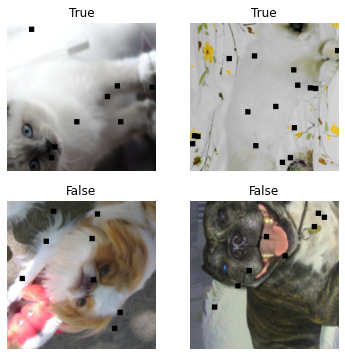

In [ ]:
dls.train.show_batch(max_n=4)

In [ ]:
#export
@delegates(Learner)
def timm_learner(dls:DataLoaders, encoder:nn.Module, cut:int, act_func:callable=nn.ReLU(inplace=True), 
                init:bool = True, state:bool = None, mod_func: callable = None, **kwargs):
    "creates a learner instance for a `timm` model"
    model = TransferLearningModel(encoder, dls.c, cut, act=act_func)
    if init: apply_init(model.fc)
    if state is not None: model.load_state_dict(torch.load(state))
    if mod_func is not None: mod_func(model)
    learn = Learner(dls, model, **kwargs)
    return learn

In [ ]:
#export
def timm_splitter(model:TransferLearningModel): 
    return [params(model.encoder), params(model.fc)]

In [ ]:
import timm

encoder = timm.create_model('resnet18')
learn = timm_learner(dls, encoder, -2, act_func=Mish(), init=True, 
                    mod_func=partial(replace_activs, func=Mish()), 
                    loss_func=nn.CrossEntropyLoss(), 
                    splitter=timm_splitter, metrics=[accuracy])

In [ ]:
learn.model

TransferLearningModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Mish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Mish()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin